# Notebook sobre como las imagenes se pueden clusterizar

La clusterización de imágenes es una técnica de aprendizaje automático no supervisado utilizada para agrupar imágenes similares en conjuntos o "clusters". Esto se logra mediante el uso de algoritmos que analizan características de las imágenes, como la intensidad de los pixels o los patrones de color, y luego asignan cada imagen a un cluster en función de su similitud con las demás imágenes en el conjunto.

Un ejemplo de un algoritmo de clusterización de imágenes es el algoritmo k-means, que funciona dividiendo las imágenes en k clusters basados en la distancia euclidiana entre las imágenes y el centroide de cada cluster. Otro algoritmo popular es el algoritmo de agrupamiento jerárquico, que agrupa las imágenes en una jerarquía de clusters basados en la similitud entre las imágenes.

La clusterización de imágenes tiene aplicaciones en una variedad de campos, como la vigilancia de vídeo, la organización de fotografías personales, y el análisis de imágenes médicas. También es útil en la etiquetación automática de imágenes, ya que las imágenes dentro de un cluster pueden ser etiquetadas con una etiqueta común.

En resumen, la clusterización de imágenes es una técnica de aprendizaje automático no supervisado que permite agrupar imágenes similares en conjuntos o "clusters" utilizando algoritmos específicos como k-means o agrupamiento jerárquico, con un gran número de aplicaciones en diferentes campos.

## Se descomprime el dataset

In [1]:
import os
import zipfile

local_zip = "archive.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("dataset/")
zip_ref.close()

## Se cargan las librerias

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Carga del dataset por medio de generadores

El uso de generadores de tensorflow nos permite inicialmente aplicar preprocesado de las imagenes, rescalado y aumento de las mismas por medio de transformaciones. 
También nos permitirá crear un flujo donde todas las imagenes no necesitan ser cargadas al mismo tiempo para poder entrenar nuestro modelo sin que se agote la memoria de 
nuestra instancia

In [2]:
train_path = "./dataset/train/"
val_path = "./dataset/validation/"

In [3]:
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rescale = 1/255)
val_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rescale = 1/255, validation_split=0.2)

In [176]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (150, 150),
    batch_size = 3000,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "training"
)

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "validation"
)

test_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
)
## El subset de test el lo asume 

Found 3115 images belonging to 36 classes.
Found 63 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


## Como se compone nuestro dataset

In [130]:
import glob 
train_classes = [clase.replace(train_path[:-1]+'\\','') for clase in glob.glob(train_path+'/*')]

## Revisando si esta balanceado

In [131]:
import pandas as pd
cantidad = [len(glob.glob(train_path+'/'+clase+'/*')) for clase in train_classes] 
dataset = {'clase':train_classes, 'cantidad': cantidad}
df = pd.DataFrame(data=dataset) 


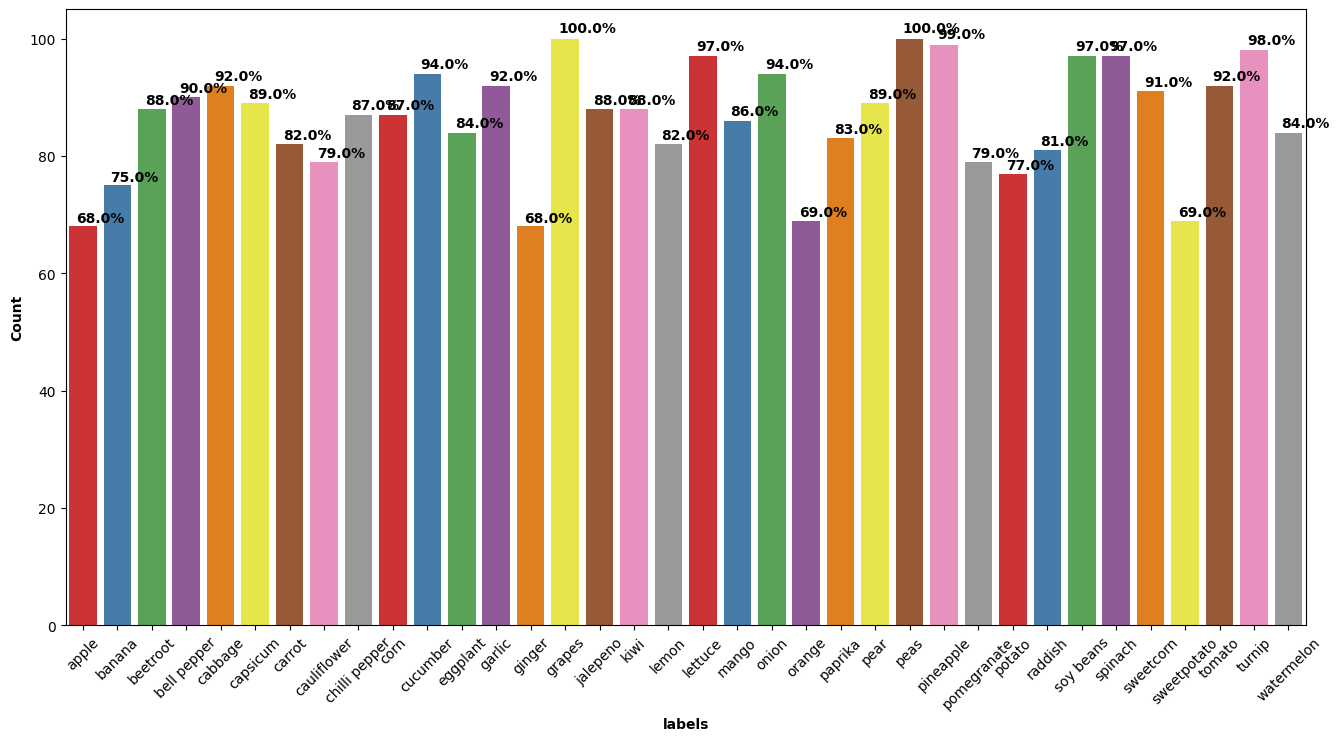

In [180]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8)) 
ax = sns.barplot(data=df,x='clase',y='cantidad',palette='Set1') 
for p in ax.patches: 
    ax.annotate(f'{round(p.get_height()/(df.cantidad.max())*100,1)}%',(p.get_x()+p.get_width()/4,p.get_height()*1.01),weight='bold')
plt.xlabel('labels', weight = 'bold') 
plt.ylabel('Count',weight= 'bold') 
plt.xticks(rotation=45) 
plt.show()

In [181]:
df['cantidad'].median()

88.0

Se puede concluir que existe un ligero desbalanceo en el dataset de entrenamiento algunas frutas y verduras como la manzana y la naranja por lo los dejan por debajo de la cantidad media de imagenes que es 88 por clase, sin embargo, continuaremos sin realizar un balanceo de los mismos para no perder información sobre las demás clases.

## Visualicemos nuestro dataset

In [293]:
def plot_images(images, clases, indeces):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.annotate(clases[indeces[i]], xy=(0, 0), xytext=(20, 0), fontsize = 12,
                xycoords='axes fraction', textcoords='offset points',
                ha='center', va='top')
        ax.axis("off")
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [134]:
def plotImages(images_arr):
  fig, axes = plt.subplots(2, 5, figsize = (50, 50))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img,aspect='auto')
    ax.axis("off")
  plt.tight_layout()
  #plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

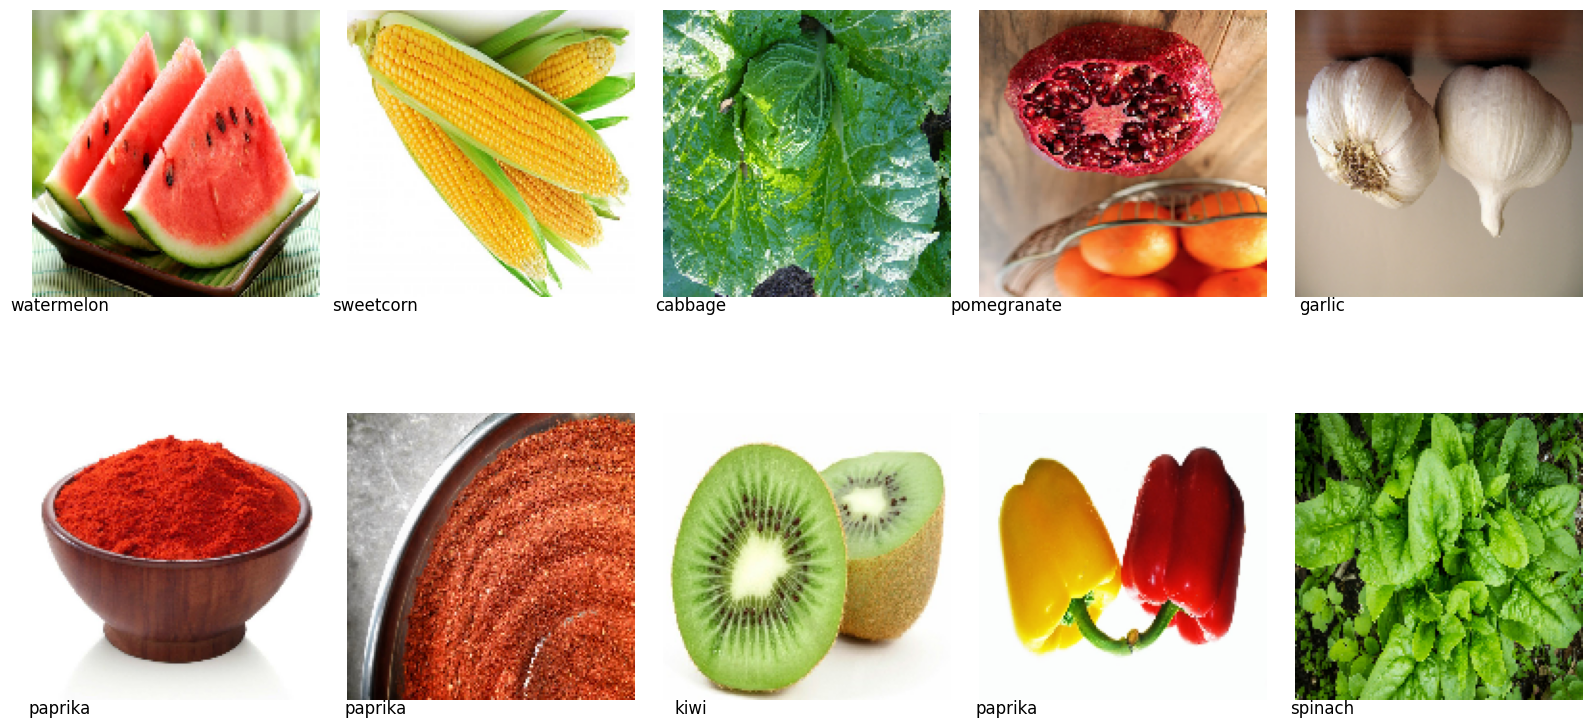

In [322]:
sample_training_images, class_one_hot_encoded = next(train_generator) #next sirve para iterar sobre un iterador 
indices = [listas.index(1) for listas in class_one_hot_encoded.astype(int).tolist()]
plot_images(sample_training_images[:11], train_classes, indices)

## Se realiza la carga de un modelo preentrenado

Por medio de la api de queras podemos cargar un modelo preentrenado con sus diferentes pesos en sus capas. Removemos las capas de densidad ya que no necesitamos clasificar sino que necesitamos es extraer las caracteristicas de las imagenes

In [136]:
import keras

In [137]:
# Load the models with ImageNet weights

vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(150,150,3))

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(150,150,3))


## Flatten (aplanar) resultados

Los modelos nos daran vectores de 3 dimensiones que representan la imagen, (width,height,ch) el canal se divide en este caso en 3 dado a su panel rojo, verde y azul (RGB) por lo que un posible resultado puede ser una imagen con estas dimensiones (150,150,3). Sin embargo necesitamos aplanar estos resultados para poder trabajar con ellos y poder clusterizarlos

In [138]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [326]:
a = vgg16_model.predict(sample_training_images)

94/94 [==============================] - 72s 768ms/step


In [339]:
vgg16_output.shape

(3000, 8192)

In [182]:
#sample_training_images, class_one_hot_encoded = next(train_generator)
vgg16_output = covnet_transform(vgg16_model, sample_training_images)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, sample_training_images)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

94/94 [==============================] - 72s 768ms/step
VGG16 flattened output has 8192 features
94/94 [==============================] - 88s 940ms/step
VGG19 flattened output has 8192 features


La celda superior nos muestra el numerdo features que cada covnet obtiene de cada imagen. Cuando comparamos estas con respecto al tamaño "original" (porque fue el que le pasamos a la red) 150x150x3 = 67500 pixeles/caracteristicas. Por lo que podemos ver una gran reduccion en cuanto a los los algoritmos de clusterización tienen que trabajar.  
Es de esperar que esta reducción del número de características represente características más significativas en la estructura de la imagen.

## Aplicacion de Analisis de componentes principales (PCA) 

Ya que queremos reducir la dimensionalidad de estas imagenes y obtener sólo sus caracteristicas más importantes se hará un analisis de componentes principales PCA. 

In [140]:
from sklearn.decomposition import PCA

In [183]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p

In [184]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)

Creamos una funcion que nos permita graficar la varianza explicada acumulada del 
analisis los componentes principales. Esto nos ayudara a decidir cuantos componentes deberíamos a reducir nuestras caracteristicas

In [185]:
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

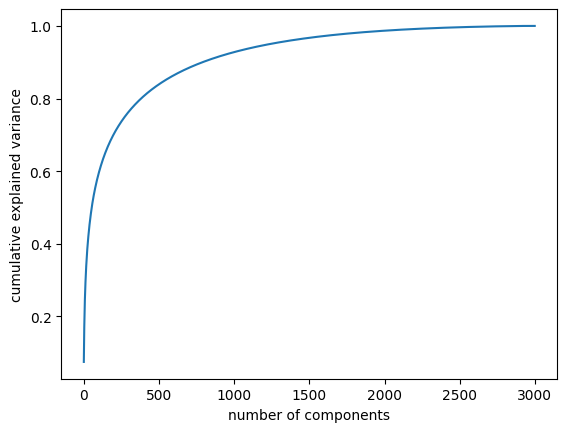

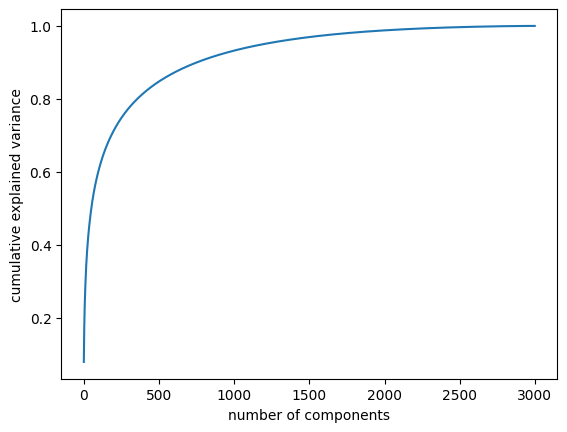

In [186]:
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)

Si observamos las brechas anteriores, podemos ver que PCA puede explicar casi toda la varianza en tantas dimensiones como muestras haya.

In [187]:
# Aplicamos una transformacion con nuestro objeto pca
#  a partir de la salida aplanada de nuestro modelo
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)

## Momento de la clusterizacion (Agrupacion)

Escribamos un par de funciones que creen y ajusten modelos KMeans y Gaussian Mixture.
Si bien puede tener sentido para combinarlos en una función que devuelve tanto, los he 
separado para que podamos ejecutar por separado y hacer algunas observaciones sin sobrecargar 
el PC

In [146]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import time

In [188]:
#Numero de clusters es la cantidad de grupos en los que queremos asignar nuestras imagenes
#recordando que tenemos 36 clases diferentes 
#vamos agruparlas en 4 grupos distintos, recordar que  a mayor numero de grupos 
# mayor será la cantidad de carga en el procesamiento.
print("La cantidad de clases es: ",len(train_classes))

La cantidad de clases es:  36


In [189]:
def create_train_kmeans(data, number_of_clusters=4):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [190]:
def create_train_gmm(data, number_of_clusters=4):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g
    

In [340]:
# Pasamos los datos al algoritmo y que prediga el cluster en el cual recae
# Como estamos usando los mismos datos del training, deberiamos de tener los mismos resultados

# Here we create and fit a KMeans model with the PCA outputs
import warnings
warnings.simplefilter('ignore')
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)


KMeans (PCA): 

VGG16
Training took 1.6026842594146729 seconds

VGG19
Training took 1.6100678443908691 seconds


In [192]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

GMM (PCA): 

VGG16
Training took 13.081214427947998 seconds

VGG19
Training took 13.187238931655884 seconds


## Ahora entrenando sin realizar pca

In [193]:

print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_sin_pca= create_train_kmeans(vgg16_output)

print("\nVGG19")
K_vgg19_sin_pca = create_train_kmeans(vgg19_output)


KMeans (PCA): 

VGG16


c:\Users\Thesu\template_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training took 6.843044757843018 seconds

VGG19


c:\Users\Thesu\template_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training took 7.136106014251709 seconds


In [52]:
# Same for Gaussian Model
#print("GMM (PCA): \n")

#print("VGG16")
#G_vgg16_sin_pca = create_train_gmm(vgg16_output)

#print("\nVGG19")
#G_vgg19_sin_pca = create_train_gmm(vgg19_output)

Los intentos de ejecutar el Modelo de Mezcla Gaussiana en las salidas sin PCA siempre dan un error de memoria agotada. Por lo tanto, no puedo probarlos y concluyo que no es práctico utilizarlos.

## Obteniendo las predicciones

In [194]:
# Now we get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16_sin_pca.predict(vgg16_output)
k_vgg19_pred = K_vgg19_sin_pca.predict(vgg19_output)

# Gaussian Mixture with PCA outputs
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

Recuerda que el algoritmo de clusterizacion no detecha que imagenes son exactamente una manzana o una naranja, solo agrupa las imagenes que tienen cierto parecido y asigna un número de forma 
arbitraria. 
Ahora necesitamos contar cuantas clases estan en cada grupo y escribir una funcion para saber cada grupo


In [195]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [196]:
#Extraemos los labels de nuestro one hot encoding
indices = [listas.index(1) for listas in class_one_hot_encoded.astype(int).tolist()]
labels = [train_classes[indices[i]] for i in range(len(indices))]

In [197]:
#Realizamos el conteo de labels en cada cluster
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, labels)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, labels)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, labels)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, labels)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, labels)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca, labels)


In [198]:
print("KMeans VGG16: ")
vgg16_cluster_count.head()

KMeans VGG16: 


0   1   2   3
mango           2  13  41  28
bell pepper     8  18  29  29
sweetpotato    13  14   9  31
chilli pepper  21  31   7  26
apple           0   6  50   9

In [199]:
print("KMeans VGG16_pca: ")
vgg16_cluster_count_pca.tail(10)

KMeans VGG16_pca: 


0   1   2   3
raddish    30  13   2  30
banana     35   6  16  14
kiwi        3  12  59  12
sweetcorn  22   8   0  56
spinach    31  41   0  23
lemon       7   7  42  24
pear        4   6  43  29
capsicum   14  21  25  25
grapes     27  66   1   4
lettuce    33  56   0   5

In [200]:
print("KMeans VGG19_pca: ")
vgg19_cluster_count_pca.tail(10)

KMeans VGG19_pca: 


0   1   2   3
raddish    23   2  20  30
banana      9  47   8   7
kiwi       24  53   5   4
sweetcorn  51  10  15  10
spinach     7   0  54  34
lemon      28  44   7   1
pear       28  45   8   1
capsicum   29  30  17   9
grapes     15   0  48  35
lettuce     3   0  55  36

In [201]:
print("KMeans VGG19_pca: ")
vgg19_cluster_count.tail(10)

KMeans VGG19_pca: 


0   1   2   3
raddish    23   2  20  30
banana      9  47   8   7
kiwi       24  53   5   4
sweetcorn  51  10  15  10
spinach     7   0  54  34
lemon      28  44   7   1
pear       28  45   8   1
capsicum   29  30  17   9
grapes     15   0  48  35
lettuce     3   0  55  36

Se puede notar que existe un gran desbalance entre las categorias, por ejemplo una lechuga esta solamente 3 veces clasificadas dentro del grupo 1 por lo que no es relevante tenerlo en este grupo, para ello vamos a crear una función que nos permita solamente tener aquellos que consideremos bajo parametro arbitrario. 

In [245]:
labels

['watermelon',
 'sweetcorn',
 'cabbage',
 'pomegranate',
 'garlic',
 'paprika',
 'paprika',
 'kiwi',
 'paprika',
 'spinach',
 'grapes',
 'watermelon',
 'ginger',
 'bell pepper',
 'cauliflower',
 'tomato',
 'lettuce',
 'tomato',
 'eggplant',
 'bell pepper',
 'watermelon',
 'peas',
 'potato',
 'turnip',
 'capsicum',
 'beetroot',
 'carrot',
 'spinach',
 'bell pepper',
 'kiwi',
 'turnip',
 'onion',
 'onion',
 'mango',
 'sweetpotato',
 'mango',
 'garlic',
 'apple',
 'beetroot',
 'mango',
 'chilli pepper',
 'paprika',
 'cabbage',
 'mango',
 'paprika',
 'kiwi',
 'capsicum',
 'pineapple',
 'pineapple',
 'onion',
 'spinach',
 'cauliflower',
 'eggplant',
 'paprika',
 'pineapple',
 'sweetcorn',
 'grapes',
 'grapes',
 'banana',
 'chilli pepper',
 'carrot',
 'paprika',
 'grapes',
 'carrot',
 'spinach',
 'eggplant',
 'bell pepper',
 'soy beans',
 'pomegranate',
 'lemon',
 'cabbage',
 'sweetcorn',
 'ginger',
 'beetroot',
 'raddish',
 'tomato',
 'banana',
 'lemon',
 'pomegranate',
 'jalepeno',
 'orang

In [252]:
#Extraemos las categorias que no cumplen con nuestra regla de minimo 20 
# imagenes asignadas en la categoria 0
clases_a_eliminar = vgg16_cluster_count[vgg16_cluster_count[0]<=20].index.tolist()

In [253]:
indices_generales = np.where(k_vgg16_pred==0)[0]

In [254]:
indices_a_eliminar = [i for i in indices_generales if labels[i] in clases_a_eliminar]

In [256]:
np.delete(k_vgg16_pred,indices_a_eliminar)

array([3, 0, 1, ..., 3, 2, 3])

Sin embargo esto nos produce otro array con nuevos indices por lo que generaria un desorden y no podriamos saber a que posición de la predicción representa cada clase. 

Por lo tanto se realizara un metodo mas adelante en el cual podamos omitir estos indices al momento de tratar de visualizar nuestro resultado

## Cluster - Asignacion de labels

En esta parte, observaremos manualmente el recuento de clusters y haremos una estimación de qué cluster corresponde a qué etiqueta. Aunque normalmente cada cluster consistirá en una etiqueta, no es necesario si el algoritmo de clustering no consigue separar las imágenes. Por lo tanto, es mejor hacer balance aquí y asegurarse de que vamos por el buen camino.

Realizamos una funcion que nos permite saber a que grupo cada clase es más familiar, por ejemplo para las predicciones dadas por la red vgg16  sin realizar su pca la clase con la que mas se familiariza ese grupo son las cebollas (onion) 

In [212]:
def most_familiar_with(df: pd.DataFrame, grupo: int) -> str: 
    return df.index[df[grupo].tolist().index(df[grupo].max())]

In [213]:
vgg16_cluster_grupo0 = most_familiar_with(vgg16_cluster_count,0)
vgg16_cluster_grupo1 = most_familiar_with(vgg16_cluster_count,1)
vgg16_cluster_grupo2 = most_familiar_with(vgg16_cluster_count,2)
vgg16_cluster_grupo3 = most_familiar_with(vgg16_cluster_count,3)

vgg16_cluster_grupo_pca0 = most_familiar_with(vgg16_cluster_count_pca,0)
vgg16_cluster_grupo_pca1 = most_familiar_with(vgg16_cluster_count_pca,1)
vgg16_cluster_grupo_pca2 = most_familiar_with(vgg16_cluster_count_pca,2)
vgg16_cluster_grupo_pca3 = most_familiar_with(vgg16_cluster_count_pca,3)

vgg19_cluster_grupo0 = most_familiar_with(vgg19_cluster_count,0)
vgg19_cluster_grupo1 = most_familiar_with(vgg19_cluster_count,1)
vgg19_cluster_grupo2 = most_familiar_with(vgg19_cluster_count,2)
vgg19_cluster_grupo3 = most_familiar_with(vgg19_cluster_count,3)

vgg19_cluster_grupo_pca0 = most_familiar_with(vgg19_cluster_count_pca,0)
vgg19_cluster_grupo_pca1 = most_familiar_with(vgg19_cluster_count_pca,1)
vgg19_cluster_grupo_pca2 = most_familiar_with(vgg19_cluster_count_pca,2)
vgg19_cluster_grupo_pca3 = most_familiar_with(vgg19_cluster_count_pca,3)

vgg16_cluster_code = [vgg16_cluster_grupo0,vgg16_cluster_grupo1,vgg16_cluster_grupo2,vgg16_cluster_grupo3]
vgg16_cluster_code_pca = [vgg16_cluster_grupo_pca0, vgg16_cluster_grupo_pca1, vgg16_cluster_grupo_pca2, vgg16_cluster_grupo_pca3]

vgg19_cluster_code = [vgg19_cluster_grupo0,vgg19_cluster_grupo1,vgg19_cluster_grupo2,vgg19_cluster_grupo3]
vgg19_cluster_code_pca = [vgg19_cluster_grupo_pca0, vgg19_cluster_grupo_pca1, vgg19_cluster_grupo_pca2, vgg19_cluster_grupo_pca3]

In [214]:
display(vgg16_cluster_code) 
display(vgg16_cluster_code_pca) 
display(vgg19_cluster_code) 
display(vgg19_cluster_code_pca) 


['pineapple', 'grapes', 'kiwi', 'sweetcorn']

['pineapple', 'grapes', 'kiwi', 'sweetcorn']

['sweetcorn', 'kiwi', 'lettuce', 'pineapple']

['sweetcorn', 'kiwi', 'lettuce', 'pineapple']

## Reemplaza los clusters predichos con las fruta o vegetal mas familiar

In [215]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]

## Vamos a verlo! 

In [216]:
def plot_images(images):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
        ax.axis("off")
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [313]:
## Con este metodo todos las clases que esten por debajo de 20 asignaciones en mi cluster 0 serán eliminadas
## esto con el fin de que solo las clases que tengan el mayor numero de asignaciones son las que queden dentro del mismo
clases_a_eliminar = vgg16_cluster_count[vgg16_cluster_count[0]<=20].index.tolist()
indices_generales = np.where(k_vgg16_pred==0)[0]
indices_a_eliminar = [i for i in indices_generales if labels[i] in clases_a_eliminar]

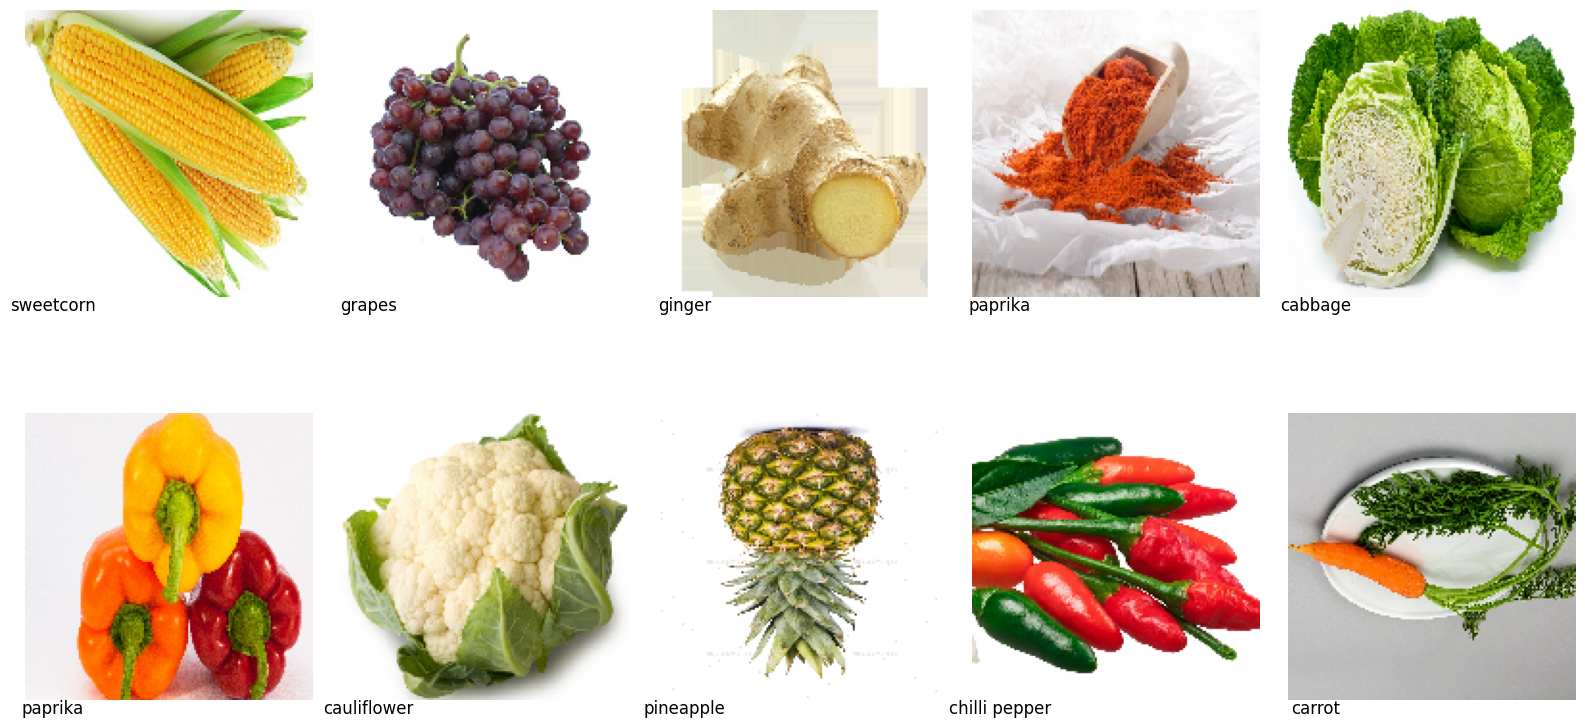

In [314]:
## los vegetales o frutas más parecidas a las features de piñas dentro de nuestro dataset son:
index_list = [i for i, x in enumerate(vgg16_pred_codes) if x == "pineapple" and i not in indices_a_eliminar]
pineapple = [sample_training_images[i] for i in index_list] 
plot_images(pineapple, labels, index_list)

In [290]:
clases_a_eliminar = vgg16_cluster_count[vgg16_cluster_count[2]<=20].index.tolist()
indices_generales = np.where(k_vgg16_pred==2)[0]
indices_a_eliminar = [i for i in indices_generales if labels[i] in clases_a_eliminar]

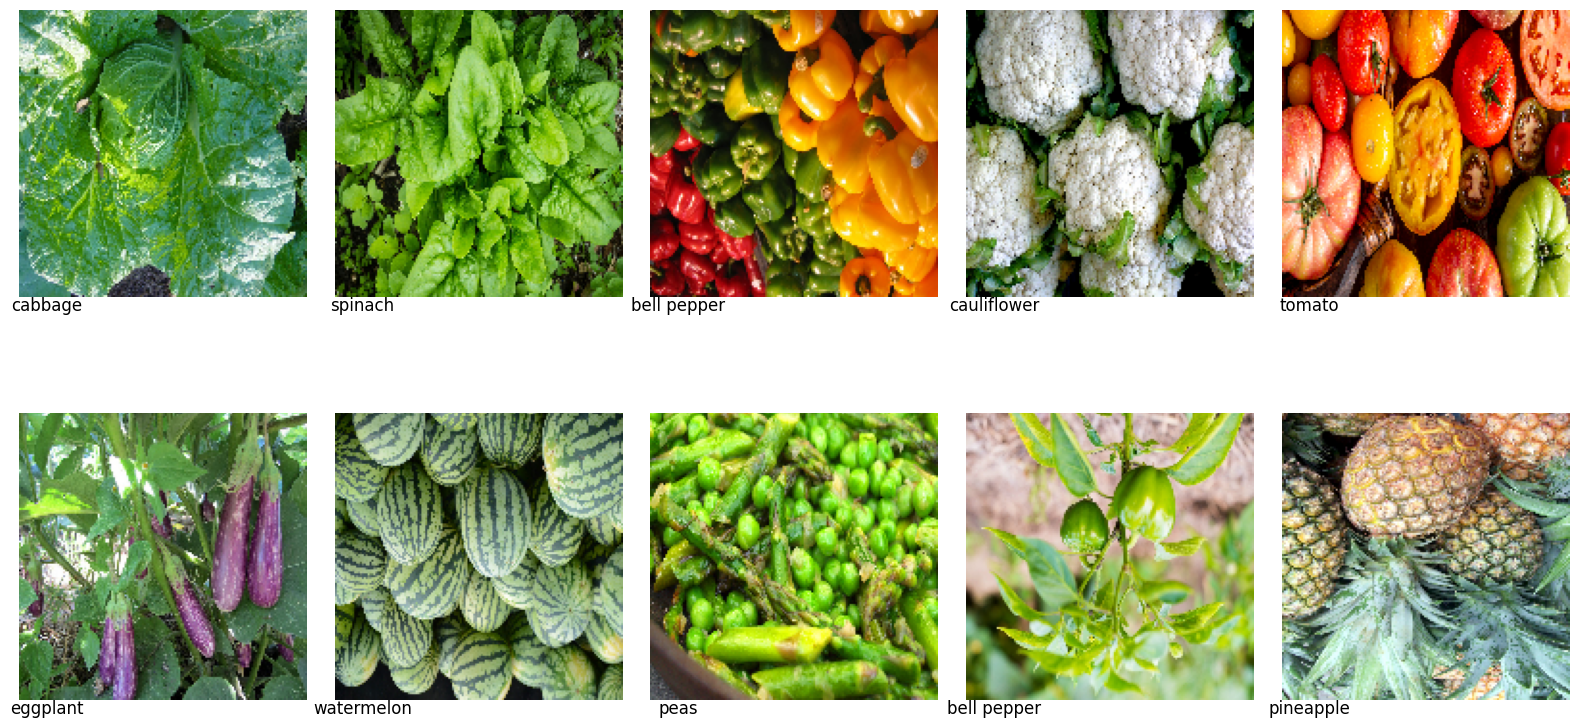

In [315]:
## los vegetales o frutas más parecidas a las features de grapes dentro de nuestro dataset son:
index_list = [i for i, x in enumerate(vgg16_pred_codes) if x == "grapes" and i not in indices_a_eliminar]
grapes = [sample_training_images[i] for i in index_list] 
plot_images(grapes, labels, index_list)

In [318]:
clases_a_eliminar = vgg16_cluster_count[vgg16_cluster_count[3]<=20].index.tolist()
indices_generales = np.where(k_vgg16_pred==3)[0]
indices_a_eliminar = [i for i in indices_generales if labels[i] in clases_a_eliminar]

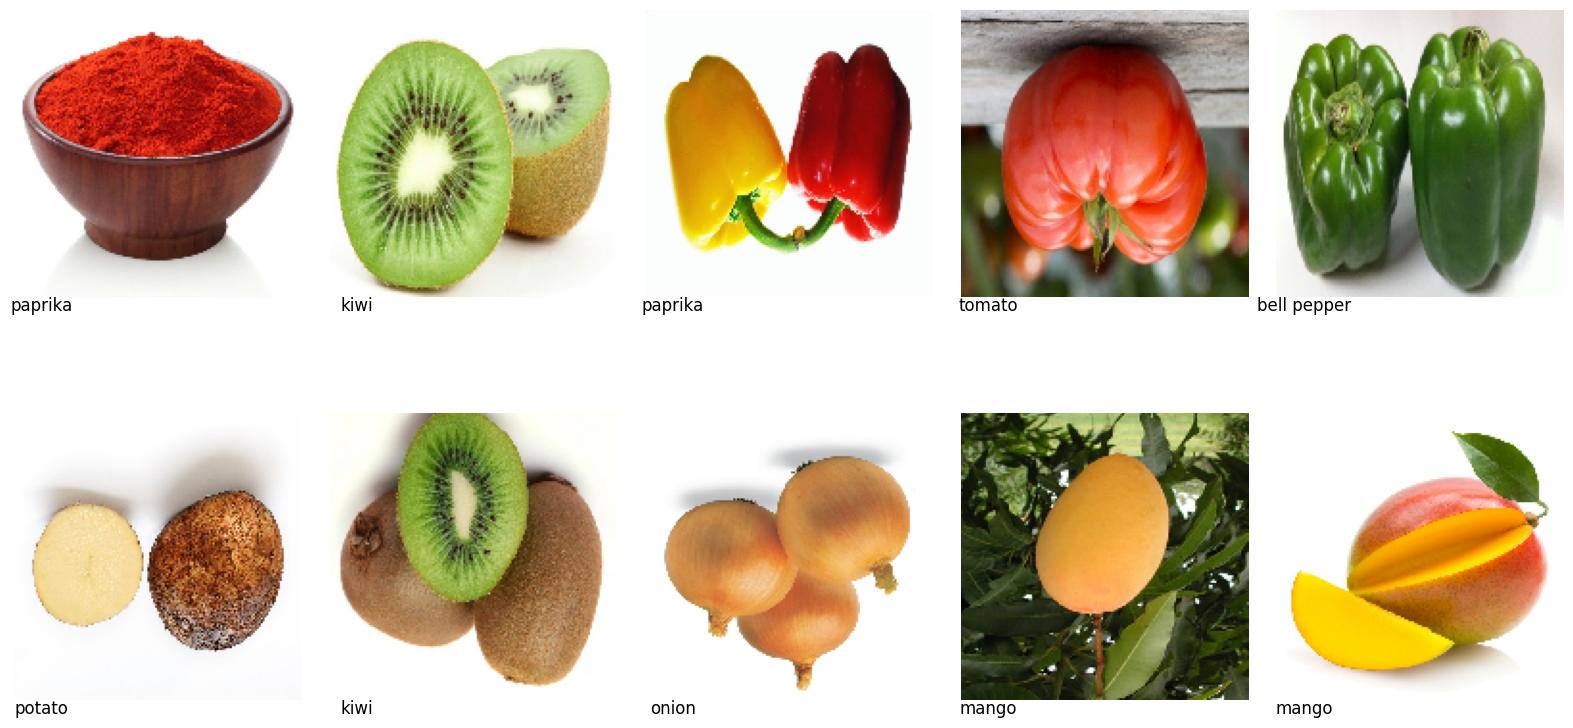

In [319]:
## los vegetales o frutas más parecidas a las features de kiwi dentro de nuestro dataset son:
index_list = [i for i, x in enumerate(vgg16_pred_codes) if x == "kiwi" and i not in indices_a_eliminar]
kiwi = [sample_training_images[i] for i in index_list] 
plot_images(kiwi, labels, index_list)

In [ ]:
clases_a_eliminar = vgg16_cluster_count[vgg16_cluster_count[3]<=20].index.tolist()
indices_generales = np.where(k_vgg16_pred==3)[0]
indices_a_eliminar = [i for i in indices_generales if labels[i] in clases_a_eliminar]

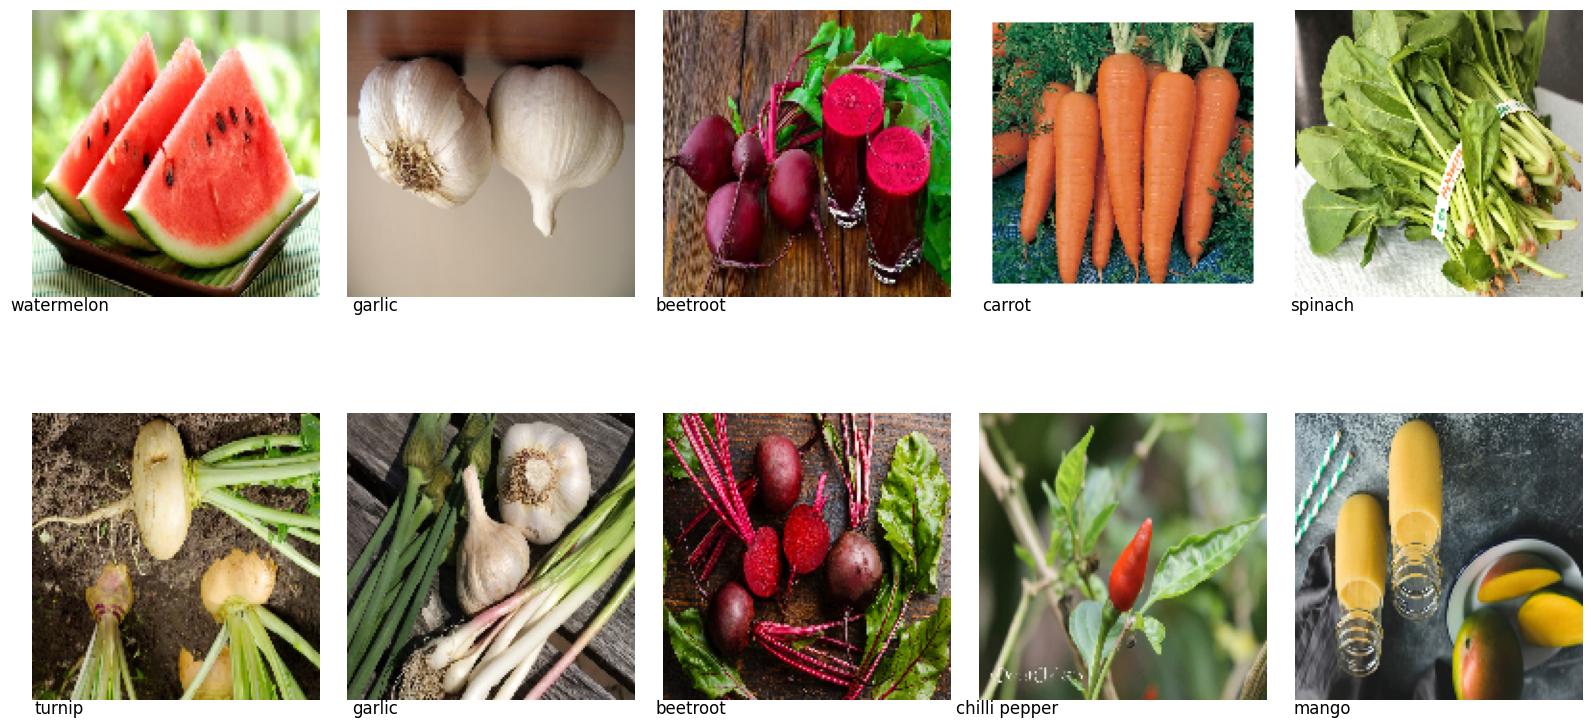

In [321]:
## los vegetales o frutas más parecidas a las features de kiwi dentro de nuestro dataset son:
index_list = [i for i, x in enumerate(vgg16_pred_codes) if x == "sweetcorn" and i not in indices_a_eliminar]
sweetcorn = [sample_training_images[i] for i in index_list] 
plot_images(sweetcorn, labels, index_list)

## NOTA: El apartado de metricas puede usarse mas adelante donde la cantidad de clusters este dada por clases especificas

## Metricas

Ahora que tenemos dos matrices, una con las etiquetas predichas y otra con las etiquetas verdaderas, podemos volvernos locos con las puntuaciones de rendimiento... o podemos simplemente calcular la puntuación F1

In [102]:
vgg16_pred_codes[0:10]

['bell pepper',
 'bell pepper',
 'onion',
 'bell pepper',
 'onion',
 'pineapple',
 'onion',
 'bell pepper',
 'bell pepper',
 'pineapple']

In [100]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(labels, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(labels, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(labels, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(labels, vgg19_pred_codes_pca))
# print("GMM VGG19 (PCA)", print_scores(y_train, g_vgg19_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.02362031   |   Accuracy: 0.02362031
KMeans VGG16 (PCA) 
	F1 Score: 0.02362031   |   Accuracy: 0.02362031

KMeans VGG19:  
	F1 Score: 0.02456780   |   Accuracy: 0.02456780
KMeans VGG19 (PCA):  
	F1 Score: 0.02456780   |   Accuracy: 0.02456780
